In [5]:
import tensorflow as tf
import tensorflow.keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =======[재현]=======

data_path = 'C:/Users/User/Desktop/Python/photofinder/data'

correct_emb = np.load(data_path + '/emb_ydata.npy')
incorrect_emb = np.load(data_path + '/emb_ndata.npy')

print(correct_emb.shape, incorrect_emb.shape)

labels_truth = np.ones((correct_emb.shape[0],), dtype='float32')  # 진실 → 1
labels_false = np.zeros((incorrect_emb.shape[0],), dtype='float32')  # 거짓 → 0

print(labels_truth.shape, labels_false.shape)

X = np.vstack((correct_emb, incorrect_emb))  # 입력 데이터 병합
y = np.hstack((labels_truth, labels_false))        # 레이블 병합

print(X.shape, y.shape)

# TensorFlow 데이터셋 생성
dataset = tf.data.Dataset.from_tensor_slices((X, y))
dataset = dataset.shuffle(buffer_size=len(X), seed=42) # 셔플

# 학습/테스트 데이터 분할 (7:3 비율)
train_size = int(len(X) * 0.7)
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

print(f"Train Dataset: {train_dataset}")
print(f"Test Dataset: {test_dataset}")

(8646, 128) (12843, 128)
(8646,) (12843,)
(21489, 128) (21489,)
Train Dataset: <TakeDataset element_spec=(TensorSpec(shape=(128,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>
Test Dataset: <SkipDataset element_spec=(TensorSpec(shape=(128,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>


In [6]:
type(train_dataset)

tensorflow.python.data.ops.dataset_ops.TakeDataset

In [7]:
X_train, y_train = [], []
for x, y in train_dataset:
    X_train.append(x.numpy())
    y_train.append(y.numpy())

X_train = np.array(X_train)
y_train = np.array(y_train)

print(f"X_train Shape: {X_train.shape}, y_train Shape: {y_train.shape}")

X_test, y_test = [], []
for x, y in test_dataset:
    X_test.append(x.numpy())
    y_test.append(y.numpy())

X_test = np.array(X_test)
y_test = np.array(y_test)

print(f"X_test Shape: {X_test.shape}, y_test Shape: {y_test.shape}")

X_train Shape: (15042, 128), y_train Shape: (15042,)
X_test Shape: (6447, 128), y_test Shape: (6447,)


# 모델 학습

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# DNN 모델 설계
model = Sequential([
    Dense(128, activation='relu', input_shape=(128,)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# 모델 컴파일
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)



# 모델 구조 확인
model.summary()

# 모델 훈련
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=20, batch_size=32, verbose=1)

# 훈련 완료
print("Model training complete!")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 49,665
Trainable params: 49,665
Non-traina

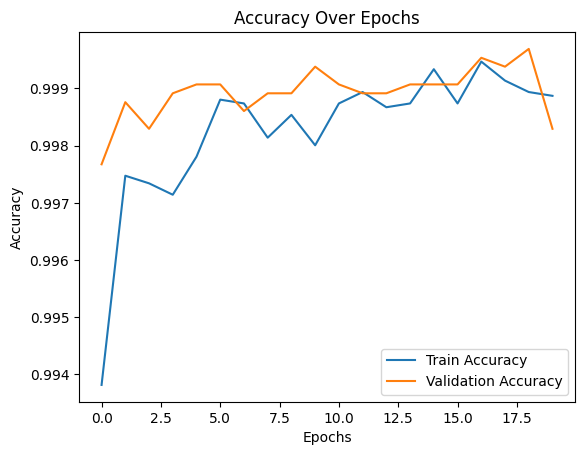

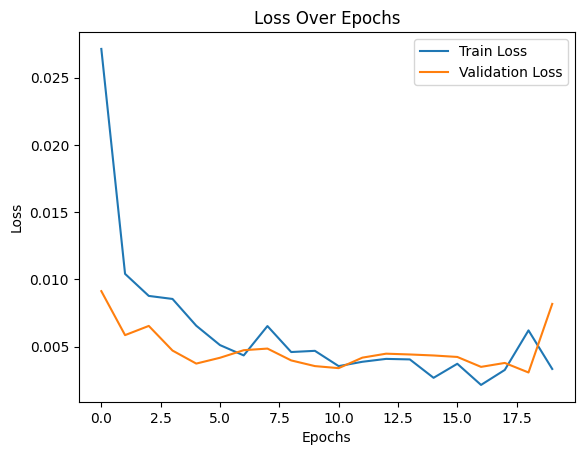

In [9]:
import matplotlib.pyplot as plt

# 훈련 정확도 및 검증 정확도 시각화
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.show()

# 훈련 손실 및 검증 손실 시각화
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()


202/202 [==============================] - 0s 2ms/step


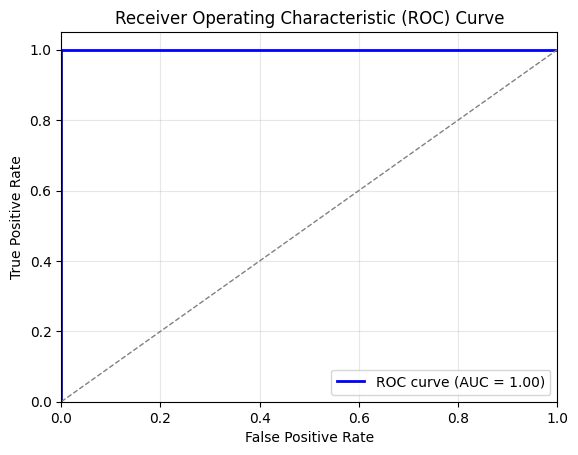

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 예측 확률 (pred_probs)와 실제 레이블 (y_test)
pred_probs = model.predict(X_test).flatten()  # 모델 예측값
y_test = y_test.flatten()  # 실제 레이블

# ROC 곡선 계산
fpr, tpr, thresholds = roc_curve(y_test, pred_probs)

# AUC 값 계산
roc_auc = auc(fpr, tpr)

# ROC 곡선 시각화
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # 기준선
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [11]:
# 모델 저장 (HDF5 형식)
model.save("C:/Users/User/Desktop/Python/photofinder/son_finder_model.h5")